### Import Libraries

Use Jupyter Notebook as Spark IDE

In [1]:
import findspark
findspark.init()

Import required libraries

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

import pandas as pd

In [3]:
sc=SparkContext.getOrCreate()
ss=SparkSession(sc)

### Load Data

Load data

In [4]:
data=ss.read.csv("../data/titanic.csv",inferSchema=True, header=True)

In [5]:
# data.cache() 

Get data structure

In [6]:
data.printSchema()

root
 |-- pclass: integer (nullable = true)
 |-- survived: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sibsp: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: double (nullable = true)
 |-- cabin: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- body: integer (nullable = true)
 |-- home.dest: string (nullable = true)



Get first 5 records

In [7]:
data.show(5)

+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+
|pclass|survived|                name|   sex|   age|sibsp|parch|ticket|    fare|  cabin|embarked|boat|body|           home.dest|
+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+
|     1|       1|Allen, Miss. Elis...|female|  29.0|    0|    0| 24160|211.3375|     B5|       S|   2|null|        St Louis, MO|
|     1|       1|Allison, Master. ...|  male|0.9167|    1|    2|113781|  151.55|C22 C26|       S|  11|null|Montreal, PQ / Ch...|
|     1|       0|Allison, Miss. He...|female|   2.0|    1|    2|113781|  151.55|C22 C26|       S|null|null|Montreal, PQ / Ch...|
|     1|       0|Allison, Mr. Huds...|  male|  30.0|    1|    2|113781|  151.55|C22 C26|       S|null| 135|Montreal, PQ / Ch...|
|     1|       0|Allison, Mrs. Hud...|female|  25.0|    1|    2|113781|  151.55|C22 C26|       S|

In [8]:
data.columns

['pclass',
 'survived',
 'name',
 'sex',
 'age',
 'sibsp',
 'parch',
 'ticket',
 'fare',
 'cabin',
 'embarked',
 'boat',
 'body',
 'home.dest']

Describe the data

In [9]:
data.describe().show(truncate=True, vertical=True)

-RECORD 0-------------------------
 summary   | count                
 pclass    | 1309                 
 survived  | 1309                 
 name      | 1309                 
 sex       | 1309                 
 age       | 1046                 
 sibsp     | 1309                 
 parch     | 1309                 
 ticket    | 1309                 
 fare      | 1308                 
 cabin     | 295                  
 embarked  | 1307                 
 boat      | 486                  
 body      | 121                  
 home.dest | 745                  
-RECORD 1-------------------------
 summary   | mean                 
 pclass    | 2.294881588999236    
 survived  | 0.3819709702062643   
 name      | null                 
 sex       | null                 
 age       | 29.8811345124283     
 sibsp     | 0.4988540870893812   
 parch     | 0.3850267379679144   
 ticket    | 249039.1368861024    
 fare      | 33.29547928134572    
 cabin     | null                 
 embarked  | null   

### Preprocess Data

Rename columns

In [10]:
data=data.withColumnRenamed('home.dest','homedest')

Check for missing values

In [11]:
from pyspark.sql import functions
for i in data.columns:
    print(i,data.where(functions.col(i).isNull()).count())

pclass 1
survived 1
name 1
sex 1
age 264
sibsp 1
parch 1
ticket 1
fare 2
cabin 1015
embarked 3
boat 824
body 1189
homedest 565


Get records with missing data column

In [12]:
data.where(data['age'].isNull()).show()

+------+--------+--------------------+------+----+-----+-----+--------+--------+-----+--------+----+----+--------------------+
|pclass|survived|                name|   sex| age|sibsp|parch|  ticket|    fare|cabin|embarked|boat|body|            homedest|
+------+--------+--------------------+------+----+-----+-----+--------+--------+-----+--------+----+----+--------------------+
|     1|       0| Baumann, Mr. John D|  male|null|    0|    0|PC 17318|  25.925| null|       S|null|null|        New York, NY|
|     1|       1|"Bradley, Mr. Geo...|  male|null|    0|    0|  111427|   26.55| null|       S|   9|null|     Los Angeles, CA|
|     1|       0|Brewe, Dr. Arthur...|  male|null|    0|    0|  112379|    39.6| null|       C|null|null|    Philadelphia, PA|
|     1|       0|Cairns, Mr. Alexa...|  male|null|    0|    0|  113798|    31.0| null|       S|null|null|                null|
|     1|       1|Cassebeer, Mrs. H...|female|null|    0|    0|   17770| 27.7208| null|       C|   5|null|      

In [13]:
data.where(data['embarked'].isNull()).show()

+------+--------+--------------------+------+----+-----+-----+------+----+-----+--------+----+----+--------------+
|pclass|survived|                name|   sex| age|sibsp|parch|ticket|fare|cabin|embarked|boat|body|      homedest|
+------+--------+--------------------+------+----+-----+-----+------+----+-----+--------+----+----+--------------+
|     1|       1| Icard, Miss. Amelie|female|38.0|    0|    0|113572|80.0|  B28|    null|   6|null|          null|
|     1|       1|Stone, Mrs. Georg...|female|62.0|    0|    0|113572|80.0|  B28|    null|   6|null|Cincinatti, OH|
|  null|    null|                null|  null|null| null| null|  null|null| null|    null|null|null|          null|
+------+--------+--------------------+------+----+-----+-----+------+----+-----+--------+----+----+--------------+



In [14]:
data.where(data['cabin'].isNull()).show(5)

+------+--------+--------------------+------+----+-----+-----+--------+-------+-----+--------+----+----+-------------------+
|pclass|survived|                name|   sex| age|sibsp|parch|  ticket|   fare|cabin|embarked|boat|body|           homedest|
+------+--------+--------------------+------+----+-----+-----+--------+-------+-----+--------+----+----+-------------------+
|     1|       0|Artagaveytia, Mr....|  male|71.0|    0|    0|PC 17609|49.5042| null|       C|null|  22|Montevideo, Uruguay|
|     1|       1|"Barber, Miss. El...|female|26.0|    0|    0|   19877|  78.85| null|       S|   6|null|               null|
|     1|       0| Baumann, Mr. John D|  male|null|    0|    0|PC 17318| 25.925| null|       S|null|null|       New York, NY|
|     1|       1|Bidois, Miss. Ros...|female|42.0|    0|    0|PC 17757|227.525| null|       C|   4|null|               null|
|     1|       0| Birnbaum, Mr. Jakob|  male|25.0|    0|    0|   13905|   26.0| null|       C|null| 148|  San Francisco, CA|


Check Data Type

In [15]:
data.dtypes

[('pclass', 'int'),
 ('survived', 'int'),
 ('name', 'string'),
 ('sex', 'string'),
 ('age', 'double'),
 ('sibsp', 'int'),
 ('parch', 'int'),
 ('ticket', 'string'),
 ('fare', 'double'),
 ('cabin', 'string'),
 ('embarked', 'string'),
 ('boat', 'string'),
 ('body', 'int'),
 ('homedest', 'string')]

Get the mean age

In [16]:
from pyspark.sql.functions import mean
data.select(mean('age')).collect()[0][0]

29.8811345124283

Impute missing age value with mean age

In [17]:
data=data.na.fill(data.select(mean('age')).collect()[0][0],subset=['age'])

In [18]:
# Check missing age records
data.where(data['age'].isNull()).show()

+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+--------+
|pclass|survived|name|sex|age|sibsp|parch|ticket|fare|cabin|embarked|boat|body|homedest|
+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+--------+
+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+--------+



Impute fare with mean fare

In [19]:
data=data.na.fill(data.select(mean('fare')).collect()[0][0],subset=['fare'])

In [20]:
# Check missing fare records
data.where(data['fare'].isNull()).show()

+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+--------+
|pclass|survived|name|sex|age|sibsp|parch|ticket|fare|cabin|embarked|boat|body|homedest|
+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+--------+
+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+--------+



Impute Embarked with Mode

In [21]:
# Get the mode of the embarked column
data.groupby("embarked").count().orderBy("count", ascending=False).first()[0]

'S'

In [22]:
# Impute the embarked with mode value
data=data.na.fill(data.groupby("embarked").count().orderBy("embarked", ascending=False).first()[0],subset=['embarked'])

In [23]:
data.where(data['embarked'].isNull()).show()

+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+--------+
|pclass|survived|name|sex|age|sibsp|parch|ticket|fare|cabin|embarked|boat|body|homedest|
+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+--------+
+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+--------+



Impute cabin with Mode

In [24]:
# Impute the embarked with mode value
data=data.na.fill(data.groupby("cabin").count().orderBy("cabin", ascending=False).first()[0],subset=['cabin'])

In [25]:
data.where(data['cabin'].isNull()).show(5)

+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+--------+
|pclass|survived|name|sex|age|sibsp|parch|ticket|fare|cabin|embarked|boat|body|homedest|
+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+--------+
+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+--------+



Count Distinct Values in Columns

In [26]:
from pyspark.sql.functions import col,countDistinct,max,min
data.agg(countDistinct(col("sex")).alias("sex")).show()

+---+
|sex|
+---+
|  2|
+---+



In [27]:
data.groupBy('sex').count().show()

+------+-----+
|   sex|count|
+------+-----+
|  null|    1|
|female|  466|
|  male|  843|
+------+-----+



In [28]:
data.agg(countDistinct(col("embarked")).alias("embarked")).show()

+--------+
|embarked|
+--------+
|       3|
+--------+



In [29]:
data.groupBy('embarked').count().show()

+--------+-----+
|embarked|count|
+--------+-----+
|       Q|  123|
|       C|  270|
|       S|  917|
+--------+-----+



In [30]:
data.agg(countDistinct(col("sibsp")).alias("sibsp")).show()

+-----+
|sibsp|
+-----+
|    7|
+-----+



In [31]:
data.groupBy('sibsp').count().show()

+-----+-----+
|sibsp|count|
+-----+-----+
| null|    1|
|    1|  319|
|    3|   20|
|    5|    6|
|    4|   22|
|    8|    9|
|    2|   42|
|    0|  891|
+-----+-----+



In [32]:
data.agg(countDistinct(col("parch")).alias("parch")).show()

+-----+
|parch|
+-----+
|    8|
+-----+



In [33]:
data.groupBy('parch').count().show()

+-----+-----+
|parch|count|
+-----+-----+
| null|    1|
|    1|  170|
|    6|    2|
|    3|    8|
|    5|    6|
|    9|    2|
|    4|    6|
|    2|  113|
|    0| 1002|
+-----+-----+



Drop all records with null target variable

In [34]:
data=data.na.drop('any',subset=['survived'])

In [35]:
for i in data.columns:
    print(i,data.where(functions.col(i).isNull()).count())

pclass 0
survived 0
name 0
sex 0
age 0
sibsp 0
parch 0
ticket 0
fare 0
cabin 0
embarked 0
boat 823
body 1188
homedest 564


In [36]:
data.show(5)

+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+
|pclass|survived|                name|   sex|   age|sibsp|parch|ticket|    fare|  cabin|embarked|boat|body|            homedest|
+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+
|     1|       1|Allen, Miss. Elis...|female|  29.0|    0|    0| 24160|211.3375|     B5|       S|   2|null|        St Louis, MO|
|     1|       1|Allison, Master. ...|  male|0.9167|    1|    2|113781|  151.55|C22 C26|       S|  11|null|Montreal, PQ / Ch...|
|     1|       0|Allison, Miss. He...|female|   2.0|    1|    2|113781|  151.55|C22 C26|       S|null|null|Montreal, PQ / Ch...|
|     1|       0|Allison, Mr. Huds...|  male|  30.0|    1|    2|113781|  151.55|C22 C26|       S|null| 135|Montreal, PQ / Ch...|
|     1|       0|Allison, Mrs. Hud...|female|  25.0|    1|    2|113781|  151.55|C22 C26|       S|

Convert sex and embarked data to numeric features

In [37]:
data.dtypes

[('pclass', 'int'),
 ('survived', 'int'),
 ('name', 'string'),
 ('sex', 'string'),
 ('age', 'double'),
 ('sibsp', 'int'),
 ('parch', 'int'),
 ('ticket', 'string'),
 ('fare', 'double'),
 ('cabin', 'string'),
 ('embarked', 'string'),
 ('boat', 'string'),
 ('body', 'int'),
 ('homedest', 'string')]

Bin age into three categories

In [38]:
from pyspark.ml.feature import Bucketizer
age_bucketizer = Bucketizer(splits=[ 0, 20, 50, 80, float('Inf') ],inputCol="age", outputCol="age_bin")
data = age_bucketizer.setHandleInvalid("keep").transform(data)

In [39]:
data.show(5)

+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+-------+
|pclass|survived|                name|   sex|   age|sibsp|parch|ticket|    fare|  cabin|embarked|boat|body|            homedest|age_bin|
+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+-------+
|     1|       1|Allen, Miss. Elis...|female|  29.0|    0|    0| 24160|211.3375|     B5|       S|   2|null|        St Louis, MO|    1.0|
|     1|       1|Allison, Master. ...|  male|0.9167|    1|    2|113781|  151.55|C22 C26|       S|  11|null|Montreal, PQ / Ch...|    0.0|
|     1|       0|Allison, Miss. He...|female|   2.0|    1|    2|113781|  151.55|C22 C26|       S|null|null|Montreal, PQ / Ch...|    0.0|
|     1|       0|Allison, Mr. Huds...|  male|  30.0|    1|    2|113781|  151.55|C22 C26|       S|null| 135|Montreal, PQ / Ch...|    1.0|
|     1|       0|Allison, Mrs. Hud...|fem

Bin fare into three categories

In [40]:
data.agg(max("fare")).show()

+---------+
|max(fare)|
+---------+
| 512.3292|
+---------+



In [41]:
data.agg(min("fare")).show()

+---------+
|min(fare)|
+---------+
|      0.0|
+---------+



In [42]:
fare_bucketizer = Bucketizer(splits=[ 0, 200, 400, 6000, float('Inf') ],inputCol="fare", outputCol="fare_bin")
data = fare_bucketizer.setHandleInvalid("keep").transform(data)

In [43]:
data.show(5)

+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+-------+--------+
|pclass|survived|                name|   sex|   age|sibsp|parch|ticket|    fare|  cabin|embarked|boat|body|            homedest|age_bin|fare_bin|
+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+-------+--------+
|     1|       1|Allen, Miss. Elis...|female|  29.0|    0|    0| 24160|211.3375|     B5|       S|   2|null|        St Louis, MO|    1.0|     1.0|
|     1|       1|Allison, Master. ...|  male|0.9167|    1|    2|113781|  151.55|C22 C26|       S|  11|null|Montreal, PQ / Ch...|    0.0|     0.0|
|     1|       0|Allison, Miss. He...|female|   2.0|    1|    2|113781|  151.55|C22 C26|       S|null|null|Montreal, PQ / Ch...|    0.0|     0.0|
|     1|       0|Allison, Mr. Huds...|  male|  30.0|    1|    2|113781|  151.55|C22 C26|       S|null| 135|Montreal, PQ / Ch

Family Size

In [44]:
data=data.withColumn("family_size", data['sibsp']+data['parch'])

In [45]:
data.groupBy('family_size').count().show()

+-----------+-----+
|family_size|count|
+-----------+-----+
|          1|  235|
|          6|   16|
|          3|   43|
|          5|   25|
|          4|   22|
|          7|    8|
|         10|   11|
|          2|  159|
|          0|  790|
+-----------+-----+



In [46]:
# Bin family size
family_bucketizer = Bucketizer(splits=[ 0, 1, 4, 30, float('Inf') ],inputCol="family_size", outputCol="family_size_bin")
data = family_bucketizer.setHandleInvalid("keep").transform(data)

In [47]:
data.show(5)

+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+-------+--------+-----------+---------------+
|pclass|survived|                name|   sex|   age|sibsp|parch|ticket|    fare|  cabin|embarked|boat|body|            homedest|age_bin|fare_bin|family_size|family_size_bin|
+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+-------+--------+-----------+---------------+
|     1|       1|Allen, Miss. Elis...|female|  29.0|    0|    0| 24160|211.3375|     B5|       S|   2|null|        St Louis, MO|    1.0|     1.0|          0|            0.0|
|     1|       1|Allison, Master. ...|  male|0.9167|    1|    2|113781|  151.55|C22 C26|       S|  11|null|Montreal, PQ / Ch...|    0.0|     0.0|          3|            1.0|
|     1|       0|Allison, Miss. He...|female|   2.0|    1|    2|113781|  151.55|C22 C26|       S|null|null|Montreal, PQ / Ch...|  

In [48]:
data.dtypes

[('pclass', 'int'),
 ('survived', 'int'),
 ('name', 'string'),
 ('sex', 'string'),
 ('age', 'double'),
 ('sibsp', 'int'),
 ('parch', 'int'),
 ('ticket', 'string'),
 ('fare', 'double'),
 ('cabin', 'string'),
 ('embarked', 'string'),
 ('boat', 'string'),
 ('body', 'int'),
 ('homedest', 'string'),
 ('age_bin', 'double'),
 ('fare_bin', 'double'),
 ('family_size', 'int'),
 ('family_size_bin', 'double')]

In [49]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer,OneHotEncoder,VectorAssembler

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data) for column in ["sex","embarked","family_size_bin","age_bin","fare_bin"]]
indexers_pipeline = Pipeline(stages=indexers)
data = indexers_pipeline.fit(data).transform(data)


# data = data.select("pclass","sibsp","parch","sex","embarked","family_size_bin","age_bin","fare_bin","survived")

# cat_columns=["pclass","sibsp","parch","sex","embarked","family_size_bin","age_bin","fare_bin"]
# stages=[]

# for i in cat_columns:
#     stringIndexer = StringIndexer(inputCol = i, outputCol = i + '_Index')
#     encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[i + "_encodecVec"])
#     stages += [stringIndexer, encoder]

# # label_stringIdx = StringIndexer(inputCol = 'survived', outputCol = 'label')
# # stages += [label_stringIdx]
    
# nume_cols = ['fare', 'age','survived']
# assemblerInputs = [c + "classVec" for c in cat_columns] + nume_cols
# assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
# stages += [assembler]

In [50]:
# from pyspark.ml import Pipeline

# pipeline = Pipeline(stages = stages)
# pipelineModel = pipeline.fit(data)
# data = pipelineModel.transform(data)
# selectedCols = ['survived', 'features'] 
# data = data.select(selectedCols)

In [51]:
data.show(2,vertical=True)

-RECORD 0-------------------------------------
 pclass                | 1                    
 survived              | 1                    
 name                  | Allen, Miss. Elis... 
 sex                   | female               
 age                   | 29.0                 
 sibsp                 | 0                    
 parch                 | 0                    
 ticket                | 24160                
 fare                  | 211.3375             
 cabin                 | B5                   
 embarked              | S                    
 boat                  | 2                    
 body                  | null                 
 homedest              | St Louis, MO         
 age_bin               | 1.0                  
 fare_bin              | 1.0                  
 family_size           | 0                    
 family_size_bin       | 0.0                  
 sex_index             | 1.0                  
 embarked_index        | 0.0                  
 family_size_

Convert string to numeric type

In [52]:
data=data.withColumn('sex_index',data.sex_index.cast('int')).withColumn('embarked_index',data.embarked_index.cast('int')).withColumn('family_size_bin_index',data.family_size_bin_index.cast('int')).withColumn('age_bin_index',data.age_bin_index.cast('int')).withColumn('fare_bin_index',data.fare_bin_index.cast('int'))

In [53]:
data.dtypes

[('pclass', 'int'),
 ('survived', 'int'),
 ('name', 'string'),
 ('sex', 'string'),
 ('age', 'double'),
 ('sibsp', 'int'),
 ('parch', 'int'),
 ('ticket', 'string'),
 ('fare', 'double'),
 ('cabin', 'string'),
 ('embarked', 'string'),
 ('boat', 'string'),
 ('body', 'int'),
 ('homedest', 'string'),
 ('age_bin', 'double'),
 ('fare_bin', 'double'),
 ('family_size', 'int'),
 ('family_size_bin', 'double'),
 ('sex_index', 'int'),
 ('embarked_index', 'int'),
 ('family_size_bin_index', 'int'),
 ('age_bin_index', 'int'),
 ('fare_bin_index', 'int')]

Drop unwanted columns

In [54]:
data=data[['pclass', 'survived', 'sibsp', 'parch', 'sex_index','embarked_index','family_size_bin_index','age_bin_index','fare_bin_index']]

In [55]:
data.show(5)

+------+--------+-----+-----+---------+--------------+---------------------+-------------+--------------+
|pclass|survived|sibsp|parch|sex_index|embarked_index|family_size_bin_index|age_bin_index|fare_bin_index|
+------+--------+-----+-----+---------+--------------+---------------------+-------------+--------------+
|     1|       1|    0|    0|        1|             0|                    0|            0|             1|
|     1|       1|    1|    2|        0|             0|                    1|            1|             0|
|     1|       0|    1|    2|        1|             0|                    1|            1|             0|
|     1|       0|    1|    2|        0|             0|                    1|            0|             0|
|     1|       0|    1|    2|        1|             0|                    1|            0|             0|
+------+--------+-----+-----+---------+--------------+---------------------+-------------+--------------+
only showing top 5 rows



Encoding Categorical features

In [56]:
cat_data=data[['pclass', 'sibsp', 'parch', 'sex_index','embarked_index','family_size_bin_index','age_bin_index','fare_bin_index']]

In [57]:
encoders = [OneHotEncoder(inputCol=indexed_column, outputCol=indexed_column+"_enc").fit(data) for indexed_column in ["pclass","sibsp","parch","sex_index","embarked_index","family_size_bin_index","age_bin_index","fare_bin_index"]]

In [58]:
encoders_pipeline = Pipeline(stages=encoders)
data = encoders_pipeline.fit(data).transform(data)

In [59]:
data.show(1, vertical=True)

-RECORD 0----------------------------------
 pclass                    | 1             
 survived                  | 1             
 sibsp                     | 0             
 parch                     | 0             
 sex_index                 | 1             
 embarked_index            | 0             
 family_size_bin_index     | 0             
 age_bin_index             | 0             
 fare_bin_index            | 1             
 pclass_enc                | (3,[1],[1.0]) 
 sibsp_enc                 | (8,[0],[1.0]) 
 parch_enc                 | (9,[0],[1.0]) 
 sex_index_enc             | (1,[],[])     
 embarked_index_enc        | (2,[0],[1.0]) 
 family_size_bin_index_enc | (2,[0],[1.0]) 
 age_bin_index_enc         | (3,[0],[1.0]) 
 fare_bin_index_enc        | (2,[1],[1.0]) 
only showing top 1 row



Create Input Vector

In [60]:
inputAssembler=['pclass_enc', 'sibsp_enc', 'parch_enc', 'sex_index_enc', 'embarked_index_enc', 'family_size_bin_index_enc', 'age_bin_index_enc', 'fare_bin_index_enc']

In [61]:
assembler=VectorAssembler(inputCols=inputAssembler,outputCol="features").transform(data)

In [62]:
assembler.show(1, vertical=True)

-RECORD 0-----------------------------------------
 pclass                    | 1                    
 survived                  | 1                    
 sibsp                     | 0                    
 parch                     | 0                    
 sex_index                 | 1                    
 embarked_index            | 0                    
 family_size_bin_index     | 0                    
 age_bin_index             | 0                    
 fare_bin_index            | 1                    
 pclass_enc                | (3,[1],[1.0])        
 sibsp_enc                 | (8,[0],[1.0])        
 parch_enc                 | (9,[0],[1.0])        
 sex_index_enc             | (1,[],[])            
 embarked_index_enc        | (2,[0],[1.0])        
 family_size_bin_index_enc | (2,[0],[1.0])        
 age_bin_index_enc         | (3,[0],[1.0])        
 fare_bin_index_enc        | (2,[1],[1.0])        
 features                  | (30,[1,3,11,21,23... 
only showing top 1 row



In [63]:
ml_data=assembler[['pclass_enc', 'sibsp_enc', 'parch_enc', 'sex_index_enc', 'embarked_index_enc', 'family_size_bin_index_enc', 'age_bin_index_enc', 'fare_bin_index_enc','features','survived']]
ml_data.show(1, vertical=True)

-RECORD 0-----------------------------------------
 pclass_enc                | (3,[1],[1.0])        
 sibsp_enc                 | (8,[0],[1.0])        
 parch_enc                 | (9,[0],[1.0])        
 sex_index_enc             | (1,[],[])            
 embarked_index_enc        | (2,[0],[1.0])        
 family_size_bin_index_enc | (2,[0],[1.0])        
 age_bin_index_enc         | (3,[0],[1.0])        
 fare_bin_index_enc        | (2,[1],[1.0])        
 features                  | (30,[1,3,11,21,23... 
 survived                  | 1                    
only showing top 1 row



Split data into training and testing sets

In [64]:
(train, test) = ml_data.randomSplit([0.7,0.3])

In [65]:
train.select('features','survived').show(5)

+--------------------+--------+
|            features|survived|
+--------------------+--------+
|(30,[13,21,25,28]...|       0|
|(30,[13,21,25,28]...|       0|
|(30,[13,21,25,28]...|       0|
|(30,[13,20,21,25,...|       0|
|(30,[13,20,21,25,...|       0|
+--------------------+--------+
only showing top 5 rows



In [66]:
test.select('features','survived').show(5)

+--------------------+--------+
|            features|survived|
+--------------------+--------+
|(30,[13,21,25,28]...|       0|
|(30,[13,20,21,25,...|       0|
|(30,[3,11,23,25,2...|       0|
|(30,[3,11,23,25,2...|       0|
|(30,[3,11,23,25,2...|       0|
+--------------------+--------+
only showing top 5 rows



# Machine Learning Modeling

## 1.RandomForestClassifier

In [67]:
from pyspark.ml.classification import RandomForestClassifier

In [68]:
rm_model=RandomForestClassifier(labelCol='survived').fit(train)
rm_model

RandomForestClassificationModel: uid=RandomForestClassifier_54fefb090cdf, numTrees=20, numClasses=2, numFeatures=30

In [69]:
rm_test_model=rm_model.transform(train)
rm_test_model

DataFrame[pclass_enc: vector, sibsp_enc: vector, parch_enc: vector, sex_index_enc: vector, embarked_index_enc: vector, family_size_bin_index_enc: vector, age_bin_index_enc: vector, fare_bin_index_enc: vector, features: vector, survived: int, rawPrediction: vector, probability: vector, prediction: double]

Evaluate Random Forest ML Model

In [70]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [71]:
print("Accuracy :")
MulticlassClassificationEvaluator(labelCol='survived',metricName='accuracy').evaluate(rm_test_model)

Accuracy :


0.8099352051835853

In [72]:
print("Precision :")
MulticlassClassificationEvaluator(labelCol='survived', metricName='weightedPrecision').evaluate(rm_test_model)

Precision :


0.8131528434946651

In [73]:
print("Recal :")
MulticlassClassificationEvaluator(labelCol='survived', metricName='weightedRecall').evaluate(rm_test_model)

Recal :


0.8099352051835853

## 2. LogisticRegression

In [74]:
from pyspark.ml.classification import LogisticRegression
log_reg = LogisticRegression(labelCol='survived')
log_reg_model = log_reg.fit(train)

In [75]:
log_reg_model_test_model=log_reg_model.transform(train)
log_reg_model_test_model

DataFrame[pclass_enc: vector, sibsp_enc: vector, parch_enc: vector, sex_index_enc: vector, embarked_index_enc: vector, family_size_bin_index_enc: vector, age_bin_index_enc: vector, fare_bin_index_enc: vector, features: vector, survived: int, rawPrediction: vector, probability: vector, prediction: double]

Evaluate Random Forest ML Model

In [76]:
print("Accuracy :")
MulticlassClassificationEvaluator(labelCol='survived',metricName='accuracy').evaluate(log_reg_model_test_model)

Accuracy :


0.8034557235421166

In [77]:
print("Precision :")
MulticlassClassificationEvaluator(labelCol='survived', metricName='weightedPrecision').evaluate(log_reg_model_test_model)

Precision :


0.8029542399680121

In [78]:
print("Recal :")
MulticlassClassificationEvaluator(labelCol='survived', metricName='weightedRecall').evaluate(log_reg_model_test_model)

Recal :


0.8034557235421167

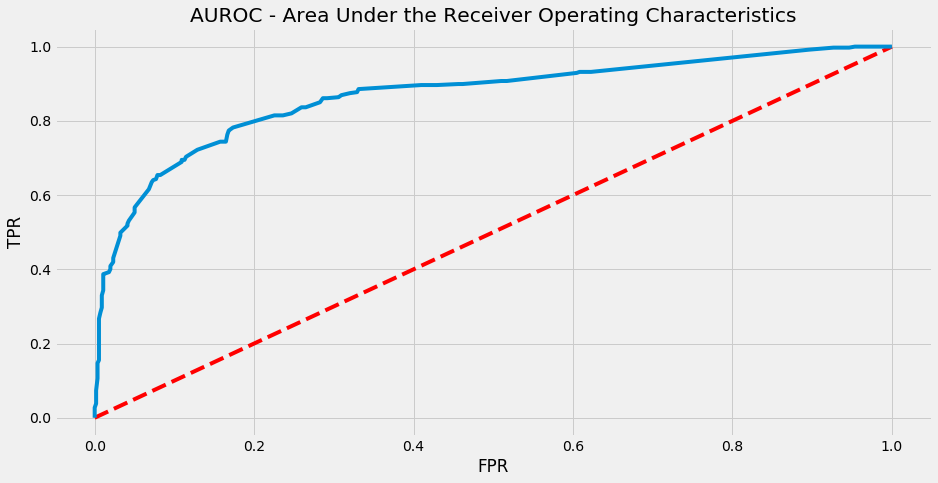

In [87]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,7))
plt.title('AUROC - Area Under the Receiver Operating Characteristics')
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(log_reg_model.summary.roc.select('FPR').collect(),
         log_reg_model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Model Testing

In [80]:
rm_test_model.show(5)

+----------+---------+-------------+-------------+------------------+-------------------------+-----------------+------------------+--------------------+--------+--------------------+--------------------+----------+
|pclass_enc|sibsp_enc|    parch_enc|sex_index_enc|embarked_index_enc|family_size_bin_index_enc|age_bin_index_enc|fare_bin_index_enc|            features|survived|       rawPrediction|         probability|prediction|
+----------+---------+-------------+-------------+------------------+-------------------------+-----------------+------------------+--------------------+--------+--------------------+--------------------+----------+
| (3,[],[])|(8,[],[])|(9,[2],[1.0])|    (1,[],[])|     (2,[0],[1.0])|                (2,[],[])|    (3,[0],[1.0])|     (2,[0],[1.0])|(30,[13,21,25,28]...|       0|[12.5931491511772...|[0.62965745755886...|       0.0|
| (3,[],[])|(8,[],[])|(9,[2],[1.0])|    (1,[],[])|     (2,[0],[1.0])|                (2,[],[])|    (3,[0],[1.0])|     (2,[0],[1.0])|(30,

In [81]:
rm_test_model.select('features','rawPrediction','survived','prediction','probability').show(5)

+--------------------+--------------------+--------+----------+--------------------+
|            features|       rawPrediction|survived|prediction|         probability|
+--------------------+--------------------+--------+----------+--------------------+
|(30,[13,21,25,28]...|[12.5931491511772...|       0|       0.0|[0.62965745755886...|
|(30,[13,21,25,28]...|[12.5931491511772...|       0|       0.0|[0.62965745755886...|
|(30,[13,21,25,28]...|[12.5931491511772...|       0|       0.0|[0.62965745755886...|
|(30,[13,20,21,25,...|[16.4314450176784...|       0|       0.0|[0.82157225088392...|
|(30,[13,20,21,25,...|[16.4314450176784...|       0|       0.0|[0.82157225088392...|
+--------------------+--------------------+--------+----------+--------------------+
only showing top 5 rows

